Problem Set 1
=============

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve as roc 
from sklearn.metrics import auc
from scipy.stats import multivariate_normal
plt.rcParams.update({
    "text.usetex": True
})

# Problem 1: Binary classification in a Gaussian toy model


Consider data generated from two different 10d Gaussians:

In [438]:
num_samples = 10000
signal=np.random.normal(size=(num_samples,10),loc=0.5)
background=np.random.normal(size=(num_samples,10),loc=0)


# Generate a test dataset for convenience
signal_test=np.random.normal(size=(int(num_samples/10),10),loc=0.5)
background_test=np.random.normal(size=(int(num_samples/10),10),loc=0)

# Configure for DataLoader
data = torch.cat([torch.from_numpy(signal), torch.from_numpy(background)])
labels = torch.from_numpy(np.append(np.ones(num_samples), np.zeros(num_samples))).to(torch.int64)


data_test = torch.cat([torch.from_numpy(signal_test), torch.from_numpy(background_test)])
labels_test = torch.from_numpy(np.append(np.ones(int(num_samples/10)), np.zeros(int(num_samples/10)))).to(torch.int64)


dataset = TensorDataset(data, labels)
test_set = TensorDataset(data_test, labels_test)

i) Perform logistic regression on this data to classify signal vs. background. Plot a ROC curve and report the AUC

ii) Compare this against the Neyman-Pearson optimal classifier. Comment on your result.

iii) Now change the width of the background from 1 to 1.5 and repeat parts (i) and (ii)

In [439]:
# First, create logistic regression module

class logistic_regression(torch.nn.Module): 
    def __init__(self, n_input, n_output):
        super(logistic_regression, self).__init__()
        self.linear = torch.nn.Linear(n_input, n_output)
    def forward(self, x): 
        return torch.sigmoid(self.linear(x))


# Now configure number of inputs and outputs. We have a binary classfier so 

n_inputs = 10
n_outputs = 2

log_reg_model = logistic_regression(n_input=n_inputs, n_output=n_outputs)
log_reg_model.to(torch.float64)
# Define our optimizer and loss fn

optimizer = torch.optim.SGD(log_reg_model.parameters(), lr=0.01)
criteria = torch.nn.CrossEntropyLoss()

# Define params
epochs = 100
batch_size=100


In [440]:
# Methods to train and test


def binary_train(model, epoch_size, dataset, optimizer, loss_fn): 
    model.train()
    dataloader = DataLoader(dataset=dataset, batch_size=100, shuffle=True)
    for epoch in range(epoch_size):
        for vectors, target in dataloader:
            optimizer.zero_grad()
            outputs = model(vectors)
            loss = criteria(outputs, target)
            loss.backward()
            optimizer.step()
# Create a method to test our model 

def test_model(model, test_dataset, dimension): 
    model.eval()
    with torch.no_grad(): 
        correct = 0
        total = 0
        incorrect = 0
        # Test every element in the dataset 
        for j, (data_arr, target_arr) in enumerate(test_dataset):
            output_pred = model(data_arr)
            # Choose which one is the most likely
            num_guess = torch.argmax(output_pred, dim=dimension)
            correct+=(num_guess==target_arr).sum().item()
            total+=target_arr.numpy().size
        print("Percent correct: ", correct/total)
        

def calc_roc(model, test_dataset):
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for vector, label in test_dataset:
            outputs = model(vector)
            y_true.append(label.numpy())
            y_score.append(outputs.numpy().squeeze()[1])
    
    fpr, tpr, thresholds = roc(y_true=y_true, y_score=y_score)
    auc_score = auc(fpr, tpr)
    
    return fpr, tpr, auc_score


def calc_roc_two(model, test_dataset):
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for vector, label in test_dataset:
            outputs = model(vector)
            y_true.append(label.numpy())
            y_score.append(outputs.numpy())
    
    fpr, tpr, thresholds = roc(y_true=y_true, y_score=y_score)
    auc_score = auc(fpr, tpr)
    
    return fpr, tpr, auc_score

In [441]:
# Train the model for 100 epochs

binary_train(model=log_reg_model, epoch_size=100, dataset=dataset, optimizer=optimizer, loss_fn=criteria)

Percent correct:  0.7925
0.875207


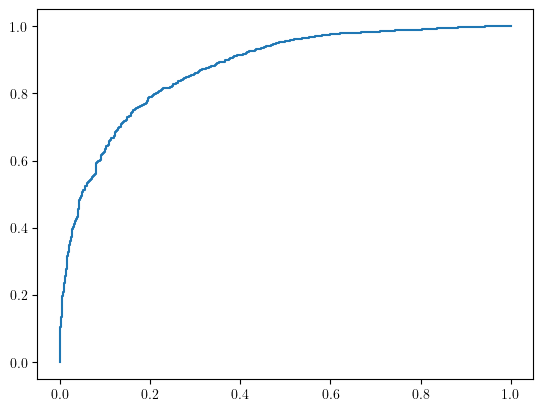

In [442]:
test_model(model=log_reg_model, test_dataset=test_set, dimension=0)

log_fpr, log_tpr, auc_log = calc_roc(log_reg_model, test_set)

plt.plot(log_fpr, log_tpr)
print(auc_log)

Using the Neyman-Pearson lemma, we expect that the theoretically optimal classifier takes the form of 
$$\Lambda(x) = \frac{P_1(x)}{P_0(x)} \geq \eta$$
where $P_0, P_1$ are the distribution functions and $\eta$ is the threshold.

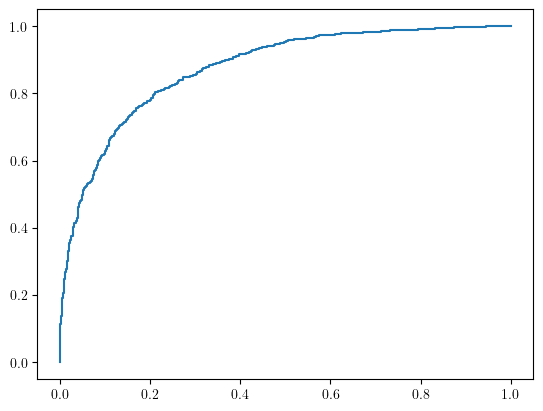

0.874976


In [443]:
# Use the Neyman-Pearson lemma to tell us the theoretically optimal, since we know a priori the distributions 

# takes 10-d x vector
def lambda_fn(x):
    return multivariate_normal(np.ones(10)*0.5).pdf(x)/multivariate_normal(np.zeros(10)).pdf(x)

# This model is super simple, we calculate our predictions and get a ROC and AUC 

y_score_lambda = []

for vector in data_test.numpy():
    y_score_lambda.append(lambda_fn(vector))

fpr_lambda, tpr_lambda, threshold = roc(y_true=labels_test.numpy(), y_score=y_score_lambda)
auc_lambda = auc(fpr_lambda, tpr_lambda)

plt.plot(fpr_lambda, tpr_lambda)
plt.show()
print(auc_lambda)


As we can see, the theoretical 0.8654 isn't too far off from the obtained 0.8649

Now, we do the same with the background spread out a bit more. 

In [444]:
background=np.random.normal(size=(10000,10),loc=0,scale=1.5)

background_test = np.random.normal(size=(int(num_samples/10), 10), loc=0, scale=3)

# Configure for DataLoader
data_torch = torch.cat([torch.from_numpy(signal), torch.from_numpy(background)])
labels_torch = torch.from_numpy(np.append(np.ones(num_samples), np.zeros(num_samples))).to(torch.int64)


data_test_torch = torch.cat([torch.from_numpy(signal_test), torch.from_numpy(background_test)])
labels_test_torch = torch.from_numpy(np.append(np.ones(int(num_samples/10)), np.zeros(int(num_samples/10)))).to(torch.int64)


dataset_spread = TensorDataset(data_torch, labels_torch)
test_set_spread= TensorDataset(data_test_torch, labels_test_torch)


In [445]:
# Train model

log_reg_spread = logistic_regression(n_inputs, n_outputs)
log_reg_spread.to(torch.float64)

optimizer_spread = torch.optim.SGD(log_reg_spread.parameters(), lr=0.01)

dataloader_spread = DataLoader(dataset=dataset_spread, batch_size=batch_size, shuffle=True)

binary_train(model=log_reg_spread,epoch_size=epochs, dataset=dataset_spread, optimizer=optimizer_spread, loss_fn=criteria)


Percent correct:  0.7005
0.688207


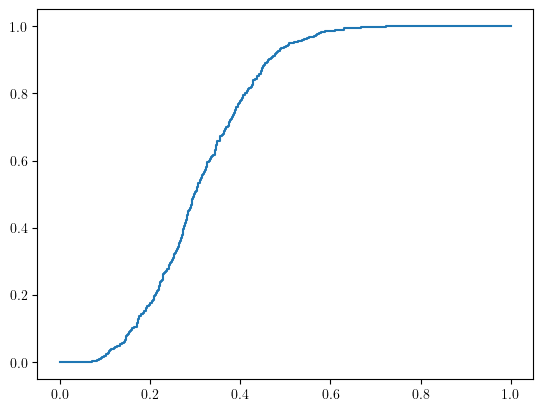

In [446]:
test_model(model=log_reg_spread, test_dataset=test_set_spread, dimension=0)

log_fpr_spread, log_tpr_spread, auc_spread = calc_roc(log_reg_spread, test_set_spread)

plt.plot(log_fpr_spread, log_tpr_spread)
print(auc_spread)

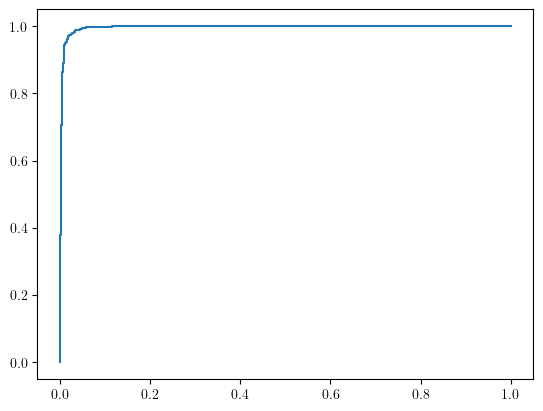

0.9962


In [447]:
# Use the Neyman-Pearson lemma to tell us the theoretically optimal, since we know a priori the distributions 

# takes 10-d x vector
def lambda_fn_spread(x):
    return multivariate_normal(mean=np.ones(10)*0.5).pdf(x)/multivariate_normal(mean=np.zeros(10), cov=1.5).pdf(x)

# This model is super simple, we calculate our predictions and get a ROC and AUC 

y_score_lambda_spread = []

for vector in data_test_torch.numpy():
    y_score_lambda_spread.append(lambda_fn_spread(vector))

fpr_lambda_spread, tpr_lambda_spread, threshold = roc(y_true=labels_test_torch.numpy(), y_score=y_score_lambda_spread)
auc_lambda_spread = auc(fpr_lambda_spread, tpr_lambda_spread)

plt.plot(fpr_lambda_spread, tpr_lambda_spread)
plt.show()
print(auc_lambda_spread)

From an intuitive standpoint, it makes sense that the logistic regression classifier performs worse—the decision threshold will now identify more points. However, for the optimal Neyman-Pearson classifier, the AUC improves probably because the background is more "spread-out" in a sense? I'm not entirely sure. 


iv) Train another method (BDT or neural network) to classify signal vs. background. How does this compare against the Neyman-Pearson optimal result?

In [448]:
# Now let's try a neural network

import torch.nn as nn

layer_size = 50
vector_dim = 10

nn_model = nn.Sequential(
    nn.Linear(vector_dim, layer_size),
    nn.Softmax(),
    nn.Linear(layer_size, layer_size),
    nn.Softmax(),
    nn.Linear(50,2),
    nn.Softmax()
)
nn_model.to(torch.float64)
loss_fn = nn.CrossEntropyLoss()
optimizer_nn = torch.optim.Adam(nn_model.parameters(), lr=0.01)

# We'll continue to use the binary cross entropy loss function for now 


In [449]:
# Train nn-model for our first case 

binary_train(model = nn_model, epoch_size=100, dataset=dataset, optimizer=optimizer_nn, loss_fn=loss_fn)


C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.8550229999999999


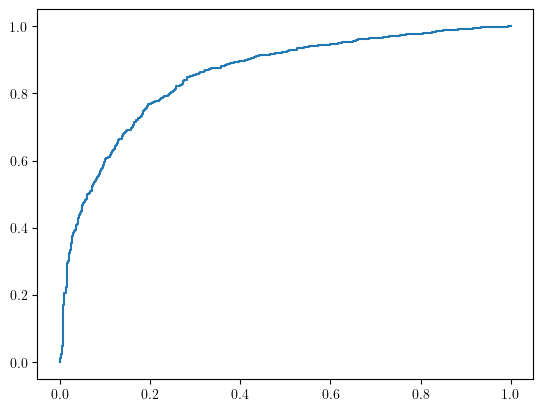

In [450]:
fpr_nn, tpr_nn, auc_nn = calc_roc(nn_model, test_dataset=test_set)
plt.plot(fpr_nn, tpr_nn)
print(auc_nn)

For our first case, we obtained a similar AUC. This is expected; we were already very close to optimal, and using a better method isn't going to get us any closer

In [451]:
# For our more spreaded out model, we'll use the same architecture as before
nn_model_spread = nn.Sequential(
    nn.Linear(vector_dim, layer_size),
    nn.Softmax(),
    nn.Linear(layer_size, layer_size),
    nn.Softmax(),
    nn.Linear(50,2),
    nn.Softmax()
)

nn_model_spread.to(torch.float64)
loss_fn = nn.CrossEntropyLoss()
optimizer_nn_spread = torch.optim.Adam(nn_model_spread.parameters(), lr=0.01)



In [452]:
binary_train(model=nn_model_spread, epoch_size=100, dataset=dataset_spread, optimizer=optimizer_nn_spread, loss_fn=loss_fn)

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.9692239999999999


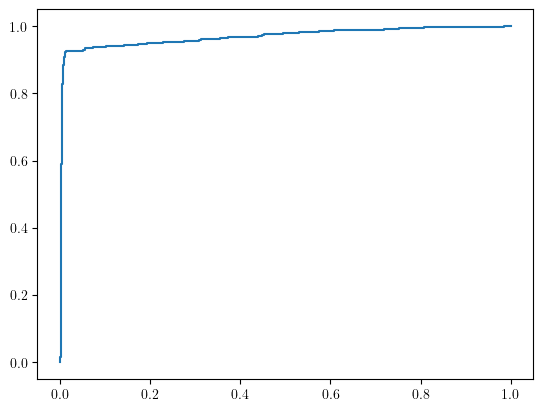

In [453]:
fpr_nn_spread, tpr_nn_spread, auc_nn_spread = calc_roc(nn_model_spread, test_dataset=test_set_spread)
plt.plot(fpr_nn_spread, tpr_nn_spread)
print(auc_nn_spread)    

I'm not sure why the neural network performed so much worse. Maybe it needs more epochs or more training points per iteration. Not sure. 

# Problem 2: MNIST example


i) Design (handcraft) a single "high level feature" that classifies the 1 digit vs the 7 digit.

ii) Train a CNN on the binary classification of 1's and 7's. How does your result compare to part (i)?

One possible handcrafted feature I can think of is that 7's have a bar at the top, whereas 1's do not. Since our MNIST images are 28x28, we can imagine a classifier that classifies a 7 as a number that has more than 8 pixels in a row being higher than some threshold value. 

In [454]:

# Import MNIST dataset

from torchvision import datasets
import torchvision.transforms as T

mnist_data = datasets.MNIST(root='data', train=True, transform = T.ToTensor(), download=False)

# We'll filter our data set to only deal with 1s or 7s 

mnist_data_tensors=list(filter(lambda x: (x[1]==1 or x[1]==7), mnist_data))

# This is very simple to do, so I'll pull it out of tensory space
mnist_data = [[x[0].squeeze().numpy(),x[1]] for x in mnist_data_tensors]

In [455]:
len_mnist = len(mnist_data)
# We know we have 13007 samples to work with now 

# Here's our rather crude classifier based off of a high-level feature
def is_seven(img): 
    for row in img:
        num_bright = len([x for x in row if x>0.5])
        if num_bright>8:
            return True
    return False


It doens't make a lot of sense to have a ROC curve for this model since it's purely binary; it's either a 1 or a 0, with no probability in between. But you could vary the `num_bright` threshold to increase or decrease the level of recognition. 

In [456]:
correct = 0
incorrect=0
for img in mnist_data:
    if is_seven(img[0]) == (img[1]==7):
        correct+=1
    else:
        incorrect+=1

In [457]:
print(correct/len_mnist)

0.9429537941108633


Frankly, I'm surprised such a crude metric got such a relatively high result.

!["sometimes_my_genius_is_almost_frightening.png"](./clarkson.jpg)

In any case, we can now do the same with a neural network. We'll use the same neural network we've been using before, with some modifications for the MNIST dataset. 

In [458]:
mnist_data_tensors=[[x[0], torch.tensor(0) if x[1]==1 else torch.tensor(1)] for x in mnist_data_tensors]

mnist_train, mnist_test = torch.utils.data.random_split(mnist_data_tensors, [10000,3007])

In [459]:
dim_mnist = 28
nn_mnist = nn.Sequential(
    nn.Flatten(),
    nn.Linear(dim_mnist**2, layer_size),
    nn.Softmax(),
    nn.Linear(layer_size, layer_size),
    nn.Softmax(),
    nn.Linear(layer_size,2),
    nn.Softmax()
)

optimizer_nn_mnist = torch.optim.Adam(nn_mnist.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

print(mnist_train)

In [460]:
binary_train(model=nn_mnist, epoch_size=100, dataset=mnist_train, optimizer=optimizer_nn_mnist, loss_fn=loss_fn)

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.9973650828521772


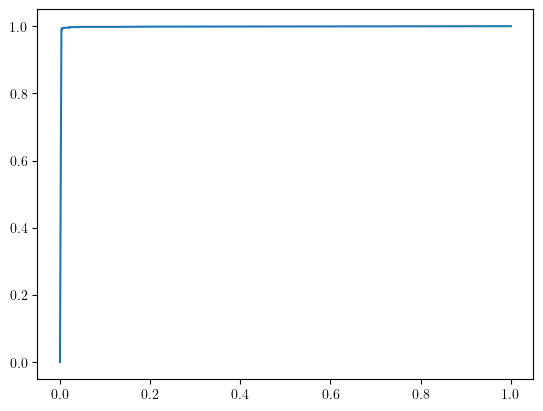

In [461]:

mnist_fpr, mnist_tpr, mnist_auc = calc_roc(nn_mnist, mnist_test)
plt.plot(mnist_fpr,mnist_tpr)
print(mnist_auc)
plt.show()


Obviously, the neural network did a much better job. 

# Problem 3: Top tagging example

In [462]:
# # First, download a set of high level features I've pre-computed for the top tagging dataset:

# if not os.path.exists('toptagging_HLF_train.npy'):
#   !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=10gppjSzIXZmMIrF4Oo5_gsyrTVucdXBa' -O 'toptagging_HLF_train.npy'
# if not os.path.exists('toptagging_HLF_val.npy'):
#   !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1dSYGrFHOjBEKBu0mZ-7hXzEp4dBG3uPk' -O 'toptagging_HLF_val.npy'
# if not os.path.exists('toptagging_HLF_test.npy'):
#   !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1gpPjB90uQuaTjYm-89MhhIT57T6gmv8X' -O 'toptagging_HLF_test.npy'


In [463]:
hlf_train=np.load('toptagging_HLF_train.npy')
hlf_val=np.load('toptagging_HLF_val.npy')
hlf_test=np.load('toptagging_HLF_test.npy')

In [464]:
# The features are (mjet,mwcandidate,tau32,label)

hlf_train.shape,hlf_val.shape,hlf_test.shape

((1211000, 4), (403000, 4), (404000, 4))

Text(0.5, 0, 'tau32')

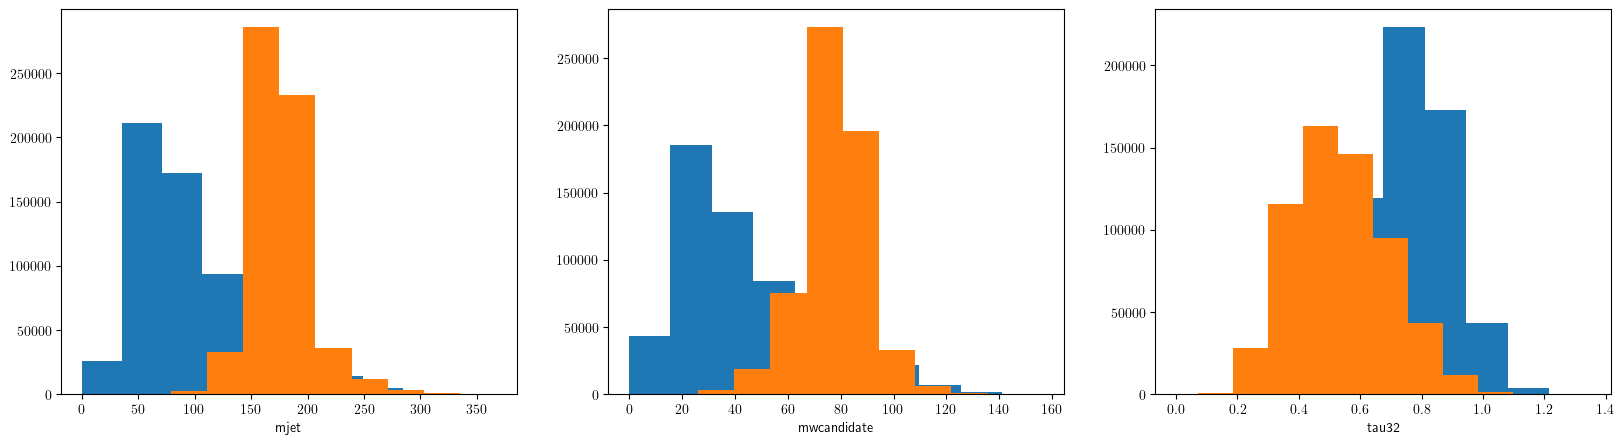

In [465]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
ax[0].hist(hlf_train[:,0][hlf_train[:,-1]==0])
ax[0].hist(hlf_train[:,0][hlf_train[:,-1]==1])
ax[0].set_xlabel('mjet')
ax[1].hist(hlf_train[:,1][hlf_train[:,-1]==0])
ax[1].hist(hlf_train[:,1][hlf_train[:,-1]==1])
ax[1].set_xlabel('mwcandidate')
ax[2].hist(hlf_train[:,2][hlf_train[:,-1]==0])
ax[2].hist(hlf_train[:,2][hlf_train[:,-1]==1])
ax[2].set_xlabel('tau32')

i) Consider a simple cut-based classifier for tops (label=1) vs QCD (label=0) using each feature separately. Which feature gives you the best classification performance? Plot the ROC curve for this feature.

ii) Now add a second feature to the best feature that you found in (i). Which second feature gives you the best performance? Scan over the cuts and plot the family of ROC curves. Report the best rejection factor at 30% signal efficiency (R30). How much better is it than part (i)?

iii) Finally, consider a cut-based classifier based on all 3 features and repeat part (ii).

iv) Now train a BDT or Neural Network on the HLFs. How does this compare to what you found above?

For feature 0 we obtain an AUC score of 0.9012770469240124 
For feature 1 we obtain an AUC score of 0.8417561295691697 
For feature 2 we obtain an AUC score of 0.1497104858843864 
0.9012770469240124


<function matplotlib.pyplot.show(close=None, block=None)>

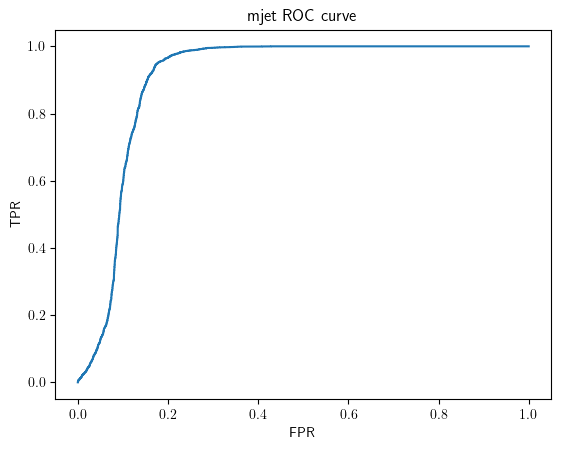

In [466]:

# In essence, for a cut the work is already done for us. All we need to do is plot ROC curves based off of the raw data, where each datum is its own likelihood score (non-normalized of course)


# Reducing the sample size for now, since we really don't need all this for simple cutting thresholding
hlf_train = hlf_train[:10000]

auc_best = 0
tpr_best = []
fpr_best = []
for i in range(3): 
    fpr_i, tpr_i, thresholds = roc(y_true=hlf_train[:,3], y_score=hlf_train[:,i])
    auc_i = auc(fpr_i, tpr_i)
    print(f"For feature {i} we obtain an AUC score of {auc_i} ")
    if auc_i>auc_best: 
        auc_best=auc_i
        tpr_best=tpr_i
        fpr_best=fpr_i

plt.plot(fpr_best, tpr_best)
print(auc_best)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("mjet ROC curve")
plt.show
    


Visually, this makes sense; the `mjet` metric is the most separated, so it would score the best on this simple cut metric.

Now let's add the other two metrics into the mix. 

In [467]:

def return_fpr_tpr (prediction, label):
    positives = prediction==1
    negatives = prediction==0
    true_pos = labels==1
    true_neg = labels==0
    
    tp = (positives) & (true_pos)
    tn = (negatives) & (true_neg)
    fp = (positives) & (true_neg)
    fn = (negatives) & (true_pos)
    
    tpr = sum(tp)/(sum(tp)+sum(fn))
    fpr = sum(fp)/(sum(fp)+sum(tn))
    
    return fpr, tpr


In [468]:
# Now, we want to scan over the family of ROC curves and find out which feature is best 


mjet_max = np.max(hlf_train[:,0])
mwcandidate_max = np.max(hlf_train[:,1])
tau32_max = np.max(hlf_train[:,2])

# Range different decision thresholds for each to create ROC curves

mjet_range = np.linspace(0,mjet_max, 25)
mwcandidate_range = np.linspace(0,mwcandidate_max, 25)
tau32_range = np.linspace(0, tau32_max, 25)

#Admittedly my confidence in this part is quite low lol... I think conceptually I'm doing the right thing??

# For first case

fpr_one = []
tpr_one = []


labels = hlf_train[:,3]


for i, mjet_threshold in enumerate(mjet_range):
    for mwcandidate_threshold in mwcandidate_range:
        prediction = np.array((hlf_train[:,0]>mjet_threshold) & (hlf_train[:,1]>mwcandidate_threshold))
        
        fpr, tpr = return_fpr_tpr(prediction=prediction, label=labels)
        
        fpr_one.append(fpr)
        tpr_one.append(tpr)



0.8937719656231996


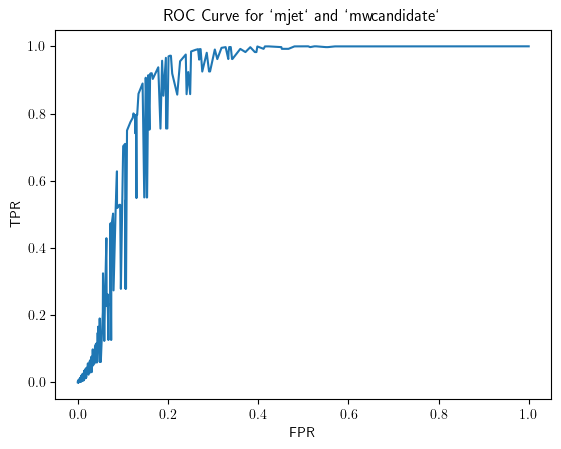

In [469]:
fpr_one, tpr_one = zip(*sorted(zip(fpr_one, tpr_one)))

auc_one = auc(fpr_one,tpr_one)
plt.plot(fpr_one, tpr_one)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve for `mjet` and `mwcandidate`")
print(auc_one)

In [470]:
# Similar to the previous part, let's do the same with the mjet and tau32

# We use a flipped decision boundary for tau32, because the distribution classification itself is flipped 
fpr_two = []
tpr_two = []
for i, mjet_threshold in enumerate(mjet_range):
    for tau32_threshold in tau32_range:
        prediction = np.array((hlf_train[:,0]>mjet_threshold) & (hlf_train[:,2]<tau32_threshold))
        
        fpr, tpr =return_fpr_tpr(prediction=prediction, label=labels)
        
        fpr_two.append(fpr)
        tpr_two.append(tpr)

0.9074944185711541


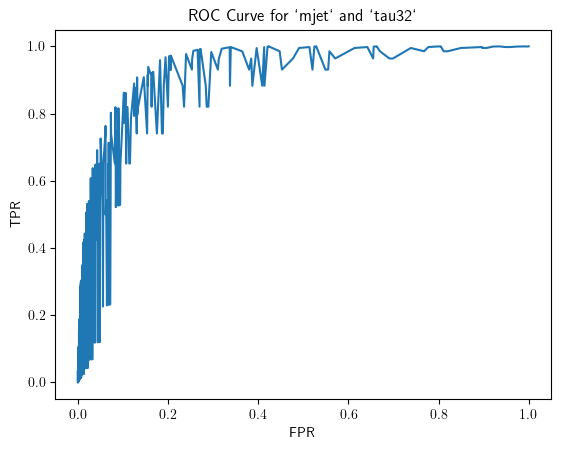

In [471]:
fpr_two, tpr_two = zip(*sorted(zip(fpr_two, tpr_two)))

auc_two = auc(fpr_two,tpr_two)
plt.plot(fpr_two, tpr_two)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve for `mjet` and `tau32`")
print(auc_two)

As we can see, it performs slightly worse in the second case, and slight better in the third. I'm not entirely sure if I'm doing these ROC curves correctly; I'm varying the thresholds to see the TPR or FPR. One could also approach it by fixing a threshold for the `mjet`, and then varying the threshold for the `mw` and `tau32` parameters. 

Now, let's do all three and get a ROC curve

In [472]:
# Now, do the same for all three


fpr_all = []
tpr_all = []
for i, mjet_threshold in enumerate(mjet_range):
    for tau32_threshold in tau32_range:
        for mw_threshold in mwcandidate_range:
            prediction = np.array((hlf_train[:,0]>mjet_threshold) & (hlf_train[:,2]<tau32_threshold) & (hlf_train[:,1]>mw_threshold))
            
            fpr, tpr =return_fpr_tpr(prediction=prediction, label=labels)
            
            fpr_all.append(fpr)
            tpr_all.append(tpr)


0.9024081764931821


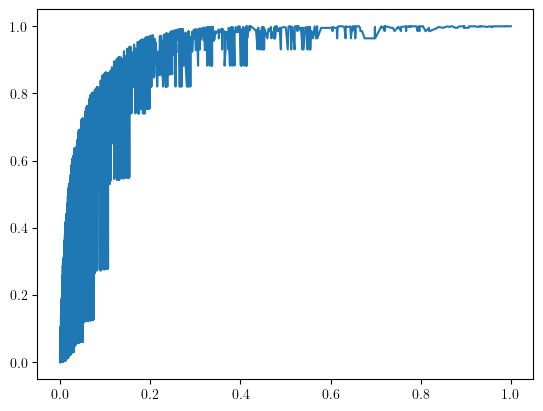

In [473]:
fpr_all, tpr_all = zip(*sorted(zip(fpr_all, tpr_all)))
auc_all = auc(fpr_all, tpr_all)
print(auc_all)
plt.plot(fpr_all, tpr_all)

There's not much more to be gained, so we're getting the same AUC. 

Now, let's train a basic neural net to perform the same task. 

In [474]:
# Finally train binary classifier

label_top_tag = hlf_train[:,3]
data_top_tag = hlf_train[:,:3]

top_tag_datset = TensorDataset(torch.from_numpy(data_top_tag),torch.from_numpy(label_top_tag).to(torch.int64))

In [475]:
nn_model_top_tagging = nn.Sequential(
    nn.Linear(3,layer_size),
    nn.Softmax(),
    nn.Linear(layer_size,layer_size),
    nn.Softmax(),
    nn.Linear(layer_size,2),
    nn.Softmax()
)
nn_model_top_tagging.to(torch.float64)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(torch.float64)
optimizer_nn_top_tag = torch.optim.Adam(nn_model_top_tagging.parameters(),lr=0.001)


In [476]:
binary_train(model=nn_model_top_tagging, epoch_size=100, dataset=top_tag_datset, optimizer=optimizer_nn_top_tag, loss_fn=loss_fn)

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.9356522469752256


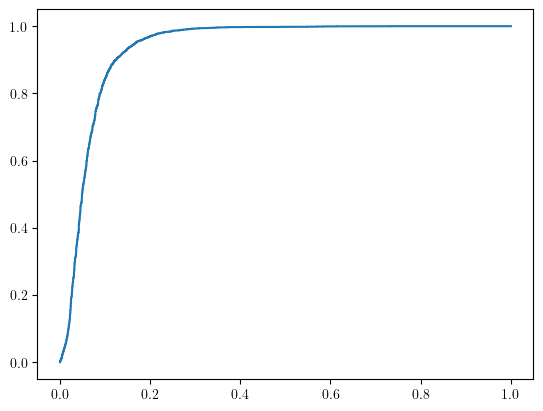

In [477]:
hlf_test = hlf_test[:10000]
hlf_test_tensor = TensorDataset(torch.from_numpy(hlf_test[:,:3]),torch.from_numpy(hlf_test[:,3]).to(torch.int64))

fpr_nn, tpr_nn, auc_nn = calc_roc(nn_model_top_tagging, hlf_test_tensor)

plt.plot(fpr_nn, tpr_nn)
print(auc_nn)

As we can see, we got much better performance, with AUC=0.93.

# Appendix
This was an attempt at making my own ROC curve algorithm. It worked, but I could fix up the indices to make it efficient so that I'm not rerunning the vector through the model every time. 

In [478]:

# I know there's probably some library for this but I wanted to code this myself, because I wanted to understand how ROC curves worked and to prove that to myself, I wanted to code one 

# It was a good exercise but I would reindex to not have to predict every time I want to calculate a new threshold lol

def calculate_roc(model, test_dataset):
    model.eval()
    with torch.no_grad():
        threshold_arr = np.linspace(0,0.99, 50)
        tpr_arr = []
        fpr_arr = []
        for threshold in threshold_arr:
            false_positive = 0
            true_positive = 0
            total_positive = 0
            total_negative = 0
            for j, (vector, target) in enumerate(test_dataset): 
                output_pred = model(vector)
                pred = 1 if output_pred.numpy()[1]>threshold else 0
                if pred==1 and target.numpy()==0:
                    # False positive
                    false_positive+=1
                    total_negative+=1
                if pred ==1 and target.numpy()==1: 
                    #true positive
                    true_positive+=1
                    total_positive+=1
                if pred == 0 and target.numpy() == 0:
                    #true negative
                    total_negative+=1
                if pred == 0 and target.numpy() ==1:
                    #false negative
                    total_positive+=1
                # Check if this prediction is correct or not 
            tpr = true_positive/total_positive
            fpr = false_positive/total_negative
            tpr_arr.append(tpr)
            fpr_arr.append(fpr)
        auc = np.trapz(y=tpr_arr, x=fpr_arr)
        print(auc)
        return auc, [tpr_arr, fpr_arr]